# Train Random Forest

In [12]:
import pandas as pd

def process_path_to_list(path):
    import wave, os, glob
    list_ = []
    if os.path.exists(path):
        for filename in glob.glob(os.path.join(path, '*.pkl')):
            list_.append(filename)
    else:
        print('Does Not Exist')

    return list_

def process_path(path):
    import wave, os, glob
    list_ = []
    if os.path.exists(path):
        for filename in glob.glob(os.path.join(path, '*.wav')):
            list_.append(filename)
    else:
         print(path + ' does not exist')   

    # ----------- process each file in the list --------- 
    from scipy.io import wavfile
    import numpy as np

    # 1. check for useful data 
    list2_ = []
    exceptions = 0
    for file in list_:
        try:
            fs, data = wavfile.read(file) # read 
            data = np.array(data, dtype=np.float32)
            list2_.append(file)
        except: 
            exceptions += 1
    print('no of exceptions: ' + str(exceptions))
    return list2_

def normalise(x):
    x = x/max(x)
    return(x)

def make_mono(data):
    try:
        if len(data[0]) == 2:
            data = np.matrix.transpose(data)
            data = normalise(data[0] + data[1])
    except:
        data = data
    return data

def downsample(fs, data, target_samplerate):
    if target_samplerate == fs/2:
        output = []
        for i in range(len(data)):
            if i%2 == 0:
                output.append(data[i])
        output_samplerate = target_samplerate
    elif target_samplerate == fs:
        output = data
        output_samplerate = fs
    else: 
        output_samplerate = fs
    return output_samplerate, output

class TimeFrameFeatures:
    
    def __init__(self, windowLength, windowOverlap, timeFrameLength, timeFrameOverlap):
        
        self.windowLength = windowLength
        self.windowOverlap = windowOverlap
        self.timeFrameLength = timeFrameLength
        self.timeFrameOverlap = timeFrameOverlap
        
        self.threshold = 0
        self.timeFrames = []
        self.MFCCFrames = []
        self.ZCRFrames = []
        self.CENTFrames = []
        self.RMSFrames = []
        self.SPEC_ENTFrames = []
        self.waveformFrames = []
        self.MFCCList = []
    
    def process_data(self, fs, data, label_array):
        from python_speech_features import mfcc

        windowsPerFrame = int(round(self.timeFrameLength/self.windowLength))
        framesPerSecond = int(round(fs * self.timeFrameLength))
        NframesPerFile = int(len(data)/(framesPerSecond*self.timeFrameOverlap))

        self.threshold = 0
        self.timeFrames = []
        self.labelFrames = []
        self.MFCCFrames = []
        self.ZCRFrames = []
        self.CENTFrames = []
        self.RMSFrames = []
        self.SPEC_ENTFrames = []
        self.waveformFrames = []
        self.MFCCList = []
        self.absTimeList = []
        for frameNum in range(NframesPerFile):
            absTime = (frameNum*self.timeFrameOverlap*self.timeFrameLength)
            C = int(round((frameNum*self.timeFrameOverlap)*framesPerSecond))
            D = int(round((frameNum*self.timeFrameOverlap+1)*framesPerSecond))
            dataFrame = data[C:D]
            labels = label_array[C:D]
            label = max(labels)

            N = int(round(fs * self.windowLength))
            c = 1
            n = 1
            o = self.windowOverlap
            No_N = len(dataFrame)/(N*o)

            ZCR = []
            CENT = []
            RMS = []
            SPEC_ENT = []
            MFCC = []
            Time_Index = []
            Waveform = []

            NFFT = 0
            Size = True
            x = 0
            for n in range(0, int(No_N)):
                A = int(round((n*o)*N))
                B = int(round((n*o+c)*N))
                block = dataFrame[A:B]
                window = np.hanning(len(block))
                block = block * window

                cross_rate = zero_cross_rate(fs, N, block)
                spec_cent = spectral_centroid(block, fs)
                rms = rms_value(block)
                spec_entropy = spectral_entropy(block)

                while Size == True:
                    if len(block) > NFFT:
                        NFFT = 2**x
                    x += 1
                    if x == 13 or NFFT > len(block):
                        break
                mfcc_values = mfcc(block, fs, winlen=self.windowLength, nfft=NFFT, winstep=(self.windowLength)*self.windowOverlap)
                MFCC.append(mfcc_values)
                ZCR.append(cross_rate)
                CENT.append(spec_cent)
                RMS.append(rms)
                SPEC_ENT.append(spec_entropy)
                time = (n*o + c/2)*N*(1/fs)
                Time_Index.append(time)

            self.absTimeList.append(absTime)
            self.timeFrames.append(Time_Index)
            self.MFCCFrames.append(MFCC)
            Out = []
            for frame in MFCC:
                frame = frame[0]
                for f in frame:
                    Out.append(f)
  
            self.MFCCList.append([Out])
            self.ZCRFrames.append(ZCR)
            self.CENTFrames.append(CENT)
            self.RMSFrames.append(RMS)
            self.SPEC_ENTFrames.append(SPEC_ENT)
            self.waveformFrames.append(dataFrame) 
            self.labelFrames.append(label)
        
            
def zero_cross_rate(fs, N, block):
    zero_crosses = np.nonzero(np.diff(block > 0))
    no_crosses = np.size(zero_crosses) * 0.5
    cross_rate = no_crosses * fs/N
    return cross_rate

def rms_value(block):
    rms = np.sqrt(np.mean(block**2))
    return rms

def spectral_centroid(block, samplerate):
    magnitudes = np.abs(np.fft.rfft(block)) # magnitudes of positive frequencies
    length = len(block)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

def spectral_entropy(block):
    BLOCK = np.fft.fft(block)
    P_w = (1/len(BLOCK))*abs(BLOCK)**2
    P_i = P_w/sum(P_w)
    
    PSE = 0
    for p in P_i:
        PSE += p * np.log(p)
    spec_entropy = -PSE
    return spec_entropy

## Filtering
import scipy.signal as sig
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, fs, highpass=125, lowpass=4000, order=5):
    data = butter_highpass_filter(data, highpass, fs, order=order)
    data = butter_lowpass_filter(data, lowpass, fs, order=order)
    return data

def makeSpeechArray(dataIn, fs, windowLength, overlap, threshold):
    dataIn = normalise(dataIn)

    samplesInWindow = windowLength*fs
    Nw = overlap*samplesInWindow
    nWindows = len(dataIn)/Nw
    nWindows = int(np.floor(nWindows))

    speechArray = np.zeros(len(dataIn))
    speechFrameArray = []
    for n in range(nWindows):
        A = int(round(n*Nw))
        B = int(round((n+1)*Nw))
        block = dataIn[A:B]
        block = np.hanning(len(block))*block

        rms = rms_value(block)
        db_rms = 20*np.log10(rms)

        if db_rms > threshold:
            speechArray[A:B] = 1
            speechFrameArray.append(1)
            
    return speechArray, speechFrameArray

# Preprocessing and Loading in Dataframes

In [21]:
dataFramePath = '/Volumes/RED_HD/DISSERTATION/Dataset2/50-50/Data_Training_Safety'
filesList = process_path_to_list(dataFramePath)

dataFrameList = []
for file in filesList:
    df = pd.read_pickle(file) 
    dataFrameList.append(df)
    
dataFrame = pd.concat(dataFrameList).reset_index(drop=True)
print(len(dataFrame))

52651


#### Remove Excess Dataframse If need be

In [22]:
REMOVE = False
# 1. randomise data in 'dataFrame'
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)

# 2. count instances of labels 
if REMOVE == True:
    count = dataFrame['Label'].value_counts()

    length = 10000000000000
    for n in range(len(count)):
        if count[n] < length:
            length = count[n]

    # 3. remove excess data 
    dataFrame0 = dataFrame[dataFrame['Label']==0].reset_index(drop=True)
    dataFrame1 = dataFrame[dataFrame['Label']==1].reset_index(drop=True)

    dataFrame0 = dataFrame0[:length]
    dataFrame1 = dataFrame1[:length]

    frameList = [dataFrame0, dataFrame1]
    dataFrame = pd.concat(frameList).reset_index(drop=True)
    count = dataFrame['Label'].value_counts()
    print(count)


Append all data in the dataframes into the form 
$$ (X_n, y_n) $$
where $X_n$ is an array of features and $y_n$ is an array of labels

In [23]:
# format
df = dataFrame

Data = []
Labels = []

for i in df.index:
    X = []
    #X.extend(df['CENT'][i])
    #X.extend(df['SPEC_ENT'][i])
    X.extend(df['ZCR'][i]) 
    X.extend(df['MFCC'][i])
    #X.extend(df['av_MFCC'][i])

    if i == 0:
        length = len(X)
    if len(X) == length:
        Data.append(X)
        Y = df['Label'][i]
        Labels.append(Y)

print(len(Labels))
print(len(Data))
print(len(df.index))

#print(len(df['CENT'][0]))
#print(len(df['SPEC_ENT'][0]))
print(len(df['ZCR'][0]))
print(len(df['MFCC'][0]))
#print(len(df['av_MFCC'][0]))

print(len(df['ZCR'][0]) + len(df['MFCC'][0]))
Training_Labels = Labels

52546
52546
52651
24
312
336


# Train Random Forest

0.959180178122859
[[14076   508]
 [  207  2725]]


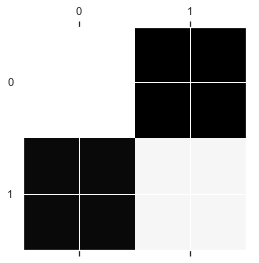

0.9638595489580359
[[14085   436]
 [  197  2797]]


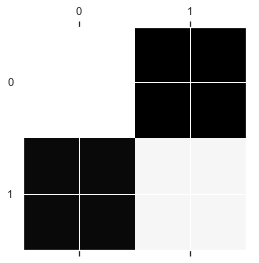

0.9617470739366257
[[14069   457]
 [  213  2776]]


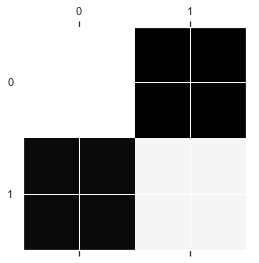

In [24]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

trees = int(50)
model = RandomForestClassifier(n_estimators = trees, n_jobs=-1, max_features='sqrt')

# Randomise data 
Data = np.array(Data)
Labels = np.array(Labels)

shuffle = np.random.permutation(len(Labels))
Data, Labels = Data[shuffle], Labels[shuffle]

FOLD = True
if FOLD == True:
    skfolds = StratifiedKFold(n_splits=3)
    for train_index, test_index in skfolds.split(Data, Labels):
        clone_ = clone(model)

        X_train_folds = Data[train_index]
        y_train_folds = Labels[train_index]
        X_test_fold = Data[test_index]
        y_test_fold = Labels[test_index]

        clone_.fit(X_train_folds, y_train_folds)
        y_pred = clone_.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred))

        conf_mx = confusion_matrix(y_pred, y_test_fold)
        print(conf_mx)

        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums

        plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
        plt.show()

### Train on Full Training Set
now that the variance of the training set has been checked through cross validation, the whole set can be used to train a random forest classifier

0.9999809690556846
[[42847     1]
 [    0  9698]]


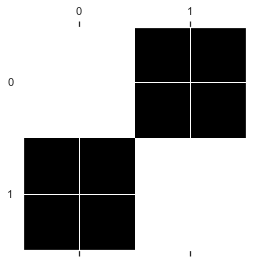

['RandomForest_50trees-108filesFalse.pkl']

In [25]:
from sklearn.externals import joblib

Path = '/Volumes/RED_HD/DISSERTATION/Machine_Learning_Models/RandomForest/'
treestr = str(trees) + 'trees'
filesstr = str(len(filesList)) + 'files'
post = treestr + '-' + filesstr
filename = 'RandomForest_' + post + str(REMOVE) + '.pkl'
path_filename = Path + filename

RandomForest = RandomForestClassifier(n_estimators = trees, n_jobs=-1, max_features='auto', oob_score=True)
X = Data
X_train = Data
y = Labels
y_train = Labels
RandomForest.fit(X, y)

# save model
joblib.dump(RandomForest, filename)
joblib.dump(RandomForest, path_filename)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = RandomForest.predict(Data)
n_correct = sum(y_pred == Labels)
print(n_correct / len(y_pred))
conf_mx = confusion_matrix(y_pred, Labels)
print(conf_mx)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

joblib.dump(RandomForest, filename)

As you can see, the `Greedy Algorithm` exausts all avalable data, so when one tests it on data it has been trained on, it correctly classifies every instance

## Testing on a Holdout set of audio samples with different speakers and  background noise levels provides a more rigorous testing of the algorithm

#### Preprocessing 

In [26]:
dataFramePath = '/Volumes/RED_HD/DISSERTATION/Dataset2/50-50/Data_Holdout_Safety'

filesList = process_path_to_list(dataFramePath)

dataFrameList = []
i = 0
n = 0
for file in filesList:
    df = pd.read_pickle(file) 
    dataFrameList.append(df)
dataFrame = pd.concat(dataFrameList).reset_index(drop=True)

# remove extra data 
REMOVE = True
# 1. randomise data in 'dataFrame'
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)

# 2. count instances of labels 
if REMOVE == True:
    count = dataFrame['Label'].value_counts()

    length = 10000000000000
    for n in range(len(count)):
        if count[n] < length:
            length = count[n]

    # 3. remove excess data 
    dataFrame0 = dataFrame[dataFrame['Label']==0].reset_index(drop=True)
    dataFrame1 = dataFrame[dataFrame['Label']==1].reset_index(drop=True)

    dataFrame0 = dataFrame0[:length]
    dataFrame1 = dataFrame1[:length]

    frameList = [dataFrame0, dataFrame1]
    dataFrame = pd.concat(frameList).reset_index(drop=True)
    count = dataFrame['Label'].value_counts()
    print(count)

df = dataFrame

Data = []
Labels = []

for i in df.index:
    X = []
    #X.extend(df['CENT'][i])
    #X.extend(df['SPEC_ENT'][i])
    X.extend(df['ZCR'][i]) 
    X.extend(df['MFCC'][i])
    #X.extend(df['av_MFCC'][i])
    
    if i == 313:
        length = len(X)
    if len(X) == length:
        Data.append(X)
        Y = df['Label'][i]
        Labels.append(Y)

Testing_Labels = Labels

1    8983
0    8983
Name: Label, dtype: int64


Accuracy : -------------
0.8812336703396569
------------------------


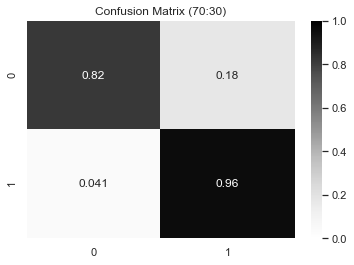

In [27]:
X_test = Data
y_pred = RandomForest.predict(Data)
n_correct = sum(y_pred == Labels)
print('Accuracy : -------------')
print(n_correct / len(y_pred))
print('------------------------')
### Confusion Matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
conf_mx = confusion_matrix(y_pred, Labels)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

import seaborn as sns; sns.set()
ax = sns.heatmap(norm_conf_mx, annot=True, vmin=0, vmax=1, cmap="Greys")
plt.title('Confusion Matrix (70:30)')
#plt.savefig('confmx_90-10_miss_after.png', dpi=700)
plt.show()

17606
17606


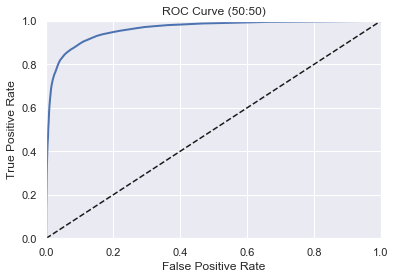

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# ROC Curve
y_score = RandomForest.predict_proba(X_test)
print(len(y_score))
print(len(Testing_Labels))
fpr, tpr, thresholds = roc_curve(Testing_Labels, np.array(y_score).T[1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
title = 'ROC Curve (50:50)'
plt.title(title)
plt.savefig(title + '.png', dpi=700)
plt.show()